# Benchmark Evaluation Script

This is the evaluation script for the `soar_ros` benchmark. This benchmark compares three different scenarios:

1. `soar_ros` running without any messaging (no load)
2. `soar_ros` running in single input/ single output (SISO) mode
3. `soar_ros` running in multiple input/ multiple output (MIMO) mode

The _no load_ scenario is intended to capture the performance baseline on the
machine running the benchmark, so relative performance can be measured. 

The general usage of the script is:

```shell
./benchmark.sh <number_of_channels> 
```

**After each frequency, press `CTRL + C` to continue to the next frequency test!** 
Tests will be completed, once you only see the log message `[INFO]
[1766760154.788314964] [system]: Soar decision cycle executed`.

In order to run the tests on your machine, run the following commands on the terminal.

1. No Messaging:

    ```shell
    ./benchmark.sh 0
    ```

    **Special case:** Just stop the benchmark with `CTRL + C` after 5-10
    seconds. There is no need for testing multiple frequencies since the Soar
    kernel is running at maximum speed in any case.

2. SISO

    ```shell
    ./benchmark.sh 1
    ```

3. MIMO

    ```shell
    ./benchmark.sh 3
    ```

The tests save the logs and extracted data via the `parse-logs.py` script into
the `out/<timestamp>/` directory. In order for the following script to analyze
and compare the different test szenarios and results, set up the correct paths
in the next cell **based on your directory names**. The directory names are in
the following schema:

```shell
./out/<ISO8601 timestamp>_CHANNELS_<number_channels>/
```

Only the `<ISO8601 timestamp>_CHANNELS_<number_channels>` part is required for the 
directory names.

In [32]:
no_load_directory = "2025-12-26T14:42:24_CHANNELS_0"
siso_directory = "2025-12-26T11:17:34_CHANNELS_1"
mimo_directory = "2025-12-26T11:18:32_CHANNELS_2"

In [33]:
# general settings & imports
# %matplotlib widget

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

export_figures = False
plt.rcParams['axes.grid'] = True

In [34]:
# Distribution plot of decision cycle frequencies (No Load) using matplotlib
# Compute histograms and normalize to 100%
def compare_soar_kernel_frequencies(data_frames, labels):
    # Accepts a list of (df, label) tuples
    # colors = plt.cm.viridis(np.linspace(0, 1, len(data_frames)))
    plt.figure()
    for (idx, df) in enumerate(data_frames):
        freqs = 1 / df["timestamp"].diff().dropna()
        hist, bins = np.histogram(freqs, bins=50)
        hist = hist / hist.sum() * 100
        bin_centers = (bins[:-1] + bins[1:]) / 2
        plt.bar(bin_centers, hist, width=(bins[1]-bins[0]), alpha=0.5, label=labels[idx])
        print(f"{labels[idx]}: Mean = {freqs.mean():.2f} Hz, SD = {freqs.std():.2f} Hz")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Count (%)")
    plt.title("Distribution of Soar Decision Cycle Frequencies (No Load, Normalized)")
    plt.legend()
    plt.show()

def analyze_sender_frequency(df):
    for freq in df["frequency"].unique():
        df_subset = df[(df["frequency"] == freq)]
        plt.figure()

        for channel in df_subset["channel"].unique():
            df_channel = df_subset[df_subset["channel"] == channel].sort_values("counter")
            plt.plot(1/df_channel["sender_time"].diff(), marker='o', linestyle='', label=f'Channel {channel} {freq} Hz', markersize=2)

            mean = df_channel["sender_time"].diff().mean()
            sd = df_channel["sender_time"].diff().std()
            print(f"Channel {channel} M: {mean:0.6} s, SD: {sd:0.6} s")

        plt.title("Sender Frequency vs Frame ID")
        plt.show()
        plt.legend()



In [35]:
# Preloading all data for comparisons
# no_load df
base_path = os.path.join("out", no_load_directory,"data")
df_no_load = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))

# SISO df
base_path = os.path.join("out", siso_directory,"data")
df_siso = pd.read_csv(os.path.join(base_path,"combined_message_results.csv"))
df_siso_soar = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))

# MIMO df
base_path = os.path.join("out", mimo_directory,"data")
df_mimo = pd.read_csv(os.path.join(base_path,"combined_message_results.csv"))
df_mimo_soar = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))

## Scenario: No Load Analysis

No Load 250 Hz: Mean = 2955.54 Hz, SD = 526.46 Hz
No Load 500 Hz: Mean = 2990.87 Hz, SD = 494.75 Hz


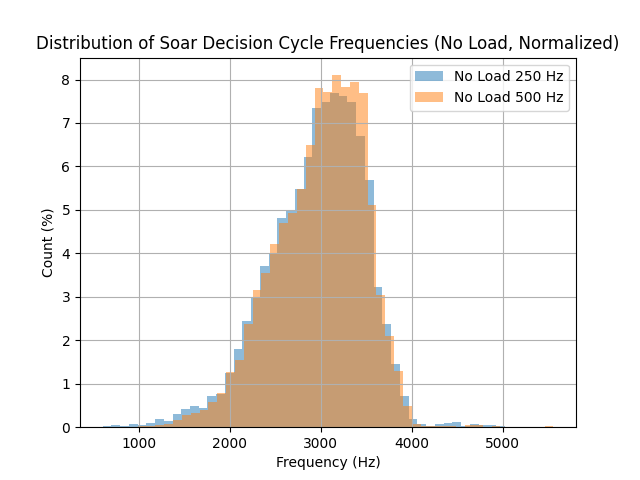

In [36]:
compare_soar_kernel_frequencies(
    [df_no_load[df_no_load["frequency"]==250.0], df_no_load[df_no_load["frequency"]==500.0]], ["No Load 250 Hz", "No Load 500 Hz"])

As visible in the distribution diagram, the input frequency does not have an impact on the Soar kernel execution speed.

## Scenario: SISO Analysis

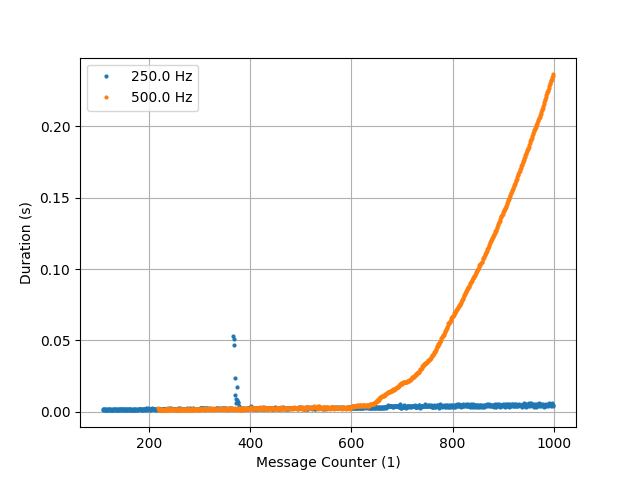

In [37]:
plt.figure()
plt.xlabel('Message Counter (1)')
plt.ylabel('Duration (s)')

for frequencies in sorted(df_siso['frequency'].unique()):
    freq_df = df_siso[df_siso['frequency'] == frequencies]
    for channel in freq_df['channel'].unique():
        df_channel = freq_df[freq_df['channel'] == channel].sort_values(by='counter')
        plt.plot(df_channel['counter'], df_channel['duration'], marker='o', linestyle='', label=f'{frequencies} Hz',markersize=2)

plt.legend()
plt.show()

SISO 250 Hz: Mean = 2647.12 Hz, SD = 749.70 Hz
SISO 500 Hz: Mean = 2746.85 Hz, SD = 694.11 Hz


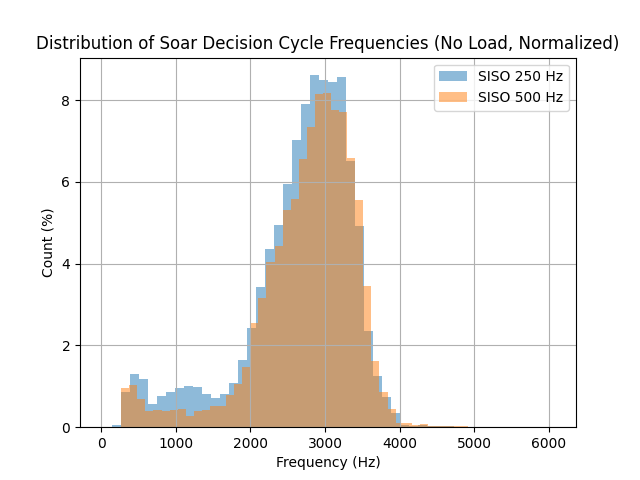

In [38]:
compare_soar_kernel_frequencies(
    [df_siso_soar[df_siso_soar["frequency"]==250.0],df_siso_soar[df_siso_soar["frequency"]==500.0]],
    ["SISO 250 Hz", "SISO 500 Hz"])

Channel 0 M: 0.00404945 s, SD: 0.000860685 s


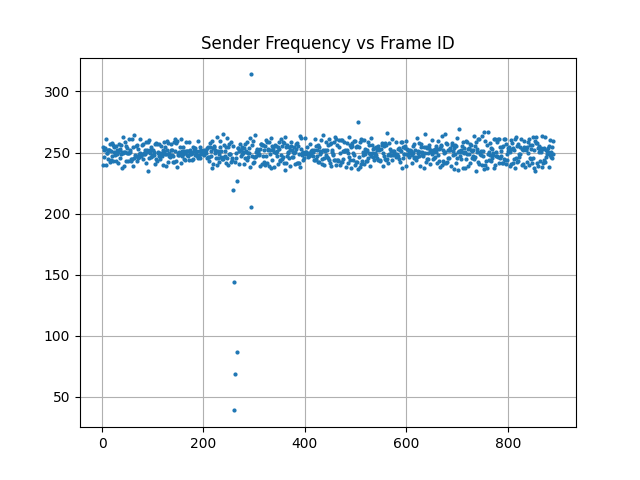

Channel 0 M: 0.00200008 s, SD: 9.51066e-05 s


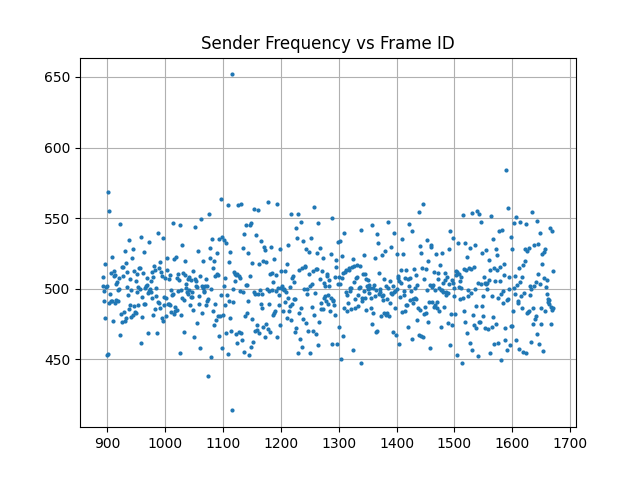

In [39]:
analyze_sender_frequency(df_siso)

In [40]:
# There could be a log time difference between the time captured in the CPP code and from the logger. We evaluate both in this script.
df_siso["receive_log_diff"] = df_siso['log_time_receiver'] - df_siso['receive_time']
print(df_siso["receive_log_diff"].diff().mean())

-1.1414414319643926e-09


## Scenario MIMO Analysis

MIMO 250 Hz: Mean = 2473.64 Hz, SD = 993.30 Hz
MIMO 500 Hz: Mean = 2886.19 Hz, SD = 567.49 Hz


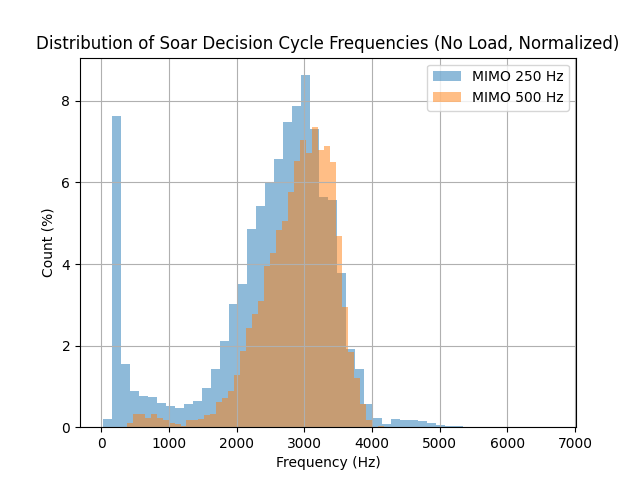

In [41]:
compare_soar_kernel_frequencies(
    [df_mimo_soar[df_mimo_soar["frequency"]==250.0],df_mimo_soar[df_mimo_soar["frequency"]==500.0]],
    ["MIMO 250 Hz", "MIMO 500 Hz"])

In [42]:
# Extract the timestamp differences (decision cycle durations) for each frequency
durations_250 = df_mimo_soar[df_mimo_soar["frequency"] == 250.0]["timestamp"].diff().dropna()
durations_500 = df_mimo_soar[df_mimo_soar["frequency"] == 500.0]["timestamp"].diff().dropna()

stat, p = mannwhitneyu(durations_250, durations_500)
print(f"Mann-Whitney U statistic: {stat:.4f}, p-value: {p:.4g}")

Mann-Whitney U statistic: 145623439.0000, p-value: 2.21e-304


Channel 1 M: 0.00400117 s, SD: 0.000577106 s
Channel 0 M: 0.00400117 s, SD: 0.000577106 s


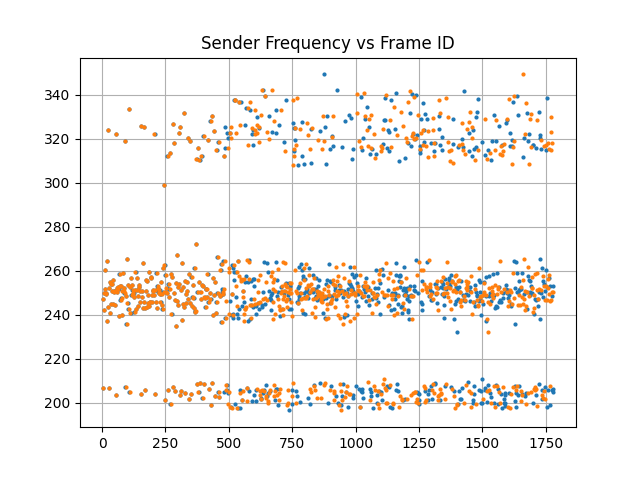

Channel 0 M: 0.0019936 s, SD: 0.000617285 s
Channel 1 M: 0.0019936 s, SD: 0.000617285 s


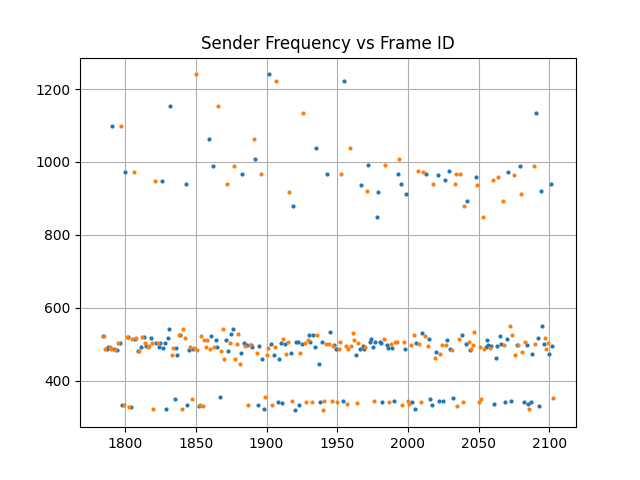

In [43]:
analyze_sender_frequency(df_mimo)

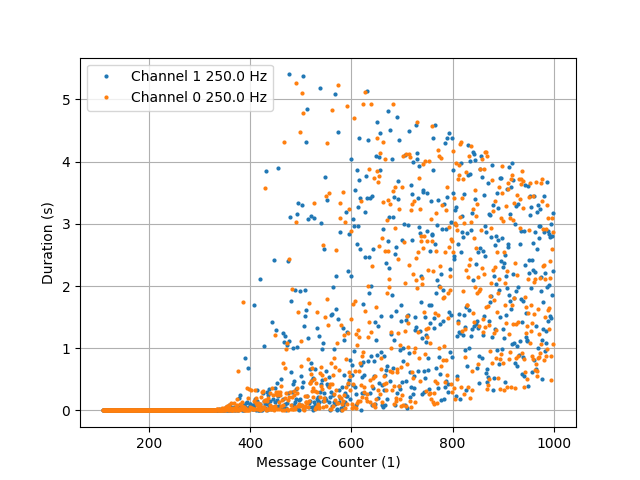

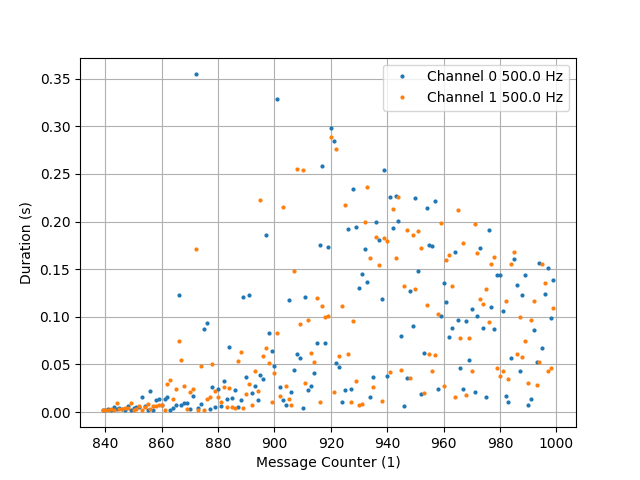

In [44]:
for frequencies in sorted(df_mimo['frequency'].unique()):
    plt.figure()
    plt.xlabel('Message Counter (1)')
    plt.ylabel('Duration (s)')

    freq_df = df_mimo[df_mimo['frequency'] == frequencies]
    for channel in freq_df['channel'].unique():
        df_channel = freq_df[freq_df['channel'] == channel].sort_values(by='counter')
        plt.plot(df_channel['counter'], df_channel['duration'], marker='o', linestyle='', label=f'Channel {channel} {frequencies} Hz',markersize=2)

    plt.legend()
    plt.show()